# Network data

Notebook by Jim Bagrow

In [1]:
# make figures better:
font = {'weight':'normal','size':16}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('figure', figsize=(9.0, 6.0))
matplotlib.rc('xtick.major', pad=8) # xticks too close to border!
matplotlib.rc('ytick.major', pad=10) # xticks too close to border!
matplotlib.rc('xtick',labelsize='small')
matplotlib.rc('ytick',labelsize='small')

import warnings
warnings.filterwarnings('ignore')

import random, math
import numpy as np
import scipy, scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
nicered = "#E6072A"
niceblu = "#424FA4"
nicegrn = "#6DC048"

## Jargon summary

Networks/graphs are (1) objects, (2) relationships between those objects

1. Nodes or vertices
2. Links or edges

Types of graphs

* **Undirected** or **directed** networks, **unweighted** or **weighted**

* Networks without **loops**/**cycles** are **trees**.

* **Planar graphs** can be drawn in the 2D plane without links crossing

* **Bipartite graphs**: Nodes can be split into two groups. Links only occur between nodes in different groups, never between nodes in the same group.

* Directed Acyclic Graphs (DAGs), no (directed) cycles, but not trees.

Specific graphs:

* **Complete graphs**: every link exists $\binom{n}{2}$ links for $n$ nodes.

* **Lattices**

* Many more

Node and graph properties:

* **Sparse**: Most pairs of nodes do not have a link.

* **Connected**: A **path** (list of nodes) exists between every pair of nodes
    + A disconnected graph has zero or more **connected components**

* Node $j$ is a **neighbor** of node $i$ if the edge $(i,j)$ exists. The **neighborhood** of $i$ is the set of all $i$'s neighbors.

* The **degree** of $i$ is the number of neighbors. The **degree distribution** $P(k)$ is the probability that a randomly chosen node in the network has degree $k$.

* **Hubs** are nodes with very high degree. In many networks (the Internet, social networks, etc.) they are rare but much more common than you may expect.

* Networks, especially those with hubs, tend to be **small world**. The paths between random pairs of nodes are much *shorter* than the number of nodes. "Six degrees of separation." The hubs act as "superhighways" that link of very separated parts of the network.

* The **distance** between nodes $i$ and $j$ is the length of the *shortest path* between them. The **diameter** of a network is the *longest* shortest path.

Triadic Closure:

* Term borrowed from the social sciences, social network analysis (SNA)

* **Triadic closure** friends of friends are likely to also be friends. Triangles form and neighborhoods tend to be **denser** (have more links) than *expected*.
    + Clustering

* **Clustering coefficient** $c_i$ of node $i$ is the fraction of neighbors of $i$ that are linked: 


$$c_i = \frac{T_i}{\binom{k_i}{2}} = \frac{2T_i}{k_i(k_i-1)}$$

where $T_i$ is the number of triangles through node $i$.

## Working with graphs/networks programmatically

(We will focus on unweighted, undirected networks.)


Let's briefly discuss how to build a network data structure ourselves, to learn what our needs are. Then we'll dive into existing libraries.

Just like with numeric or tabular data, which has a design matrix, we need a nice **data structure** for network data. 

* It should be easy to interact with and can be written to files for storage and sharing between different programs.

It's natural to have ID numbers for the nodes. Say the network has $N$ nodes total. We could number the nodes from $0$ to $N-1$ (ie, `range(N)`). But in fact we may want to use names (`alice`, `bob`, `carol`, ...). So it would be very nice to only need $N$ **unique** items (numbers, strings, etc.) to define the $N$ nodes.

* Ah ha! We're talking about a dictionary!

So, let's make a dictionary that maps **nodes** to their neighbors:

In [ ]:
node2neighbors = {
    "alice" : ["bob", "carol"],
    "bob":    ["alice","carol"],
    "carol":  ["alice","bob"]
}

That's a network! Plug in a node and we get the list of friends (neighbors). Each person in our tiny network is friends with the other two.

If we want a function to get the degree of a node all we need now is:

In [ ]:
def degree(n2ns, n):
    """n2ns is a dict mapping nodes to lists of neighbors.
    Compute the degree of node `n`.
    """
    neighbors_n = n2ns[n]
    return len(neighbors_n)
    
print("k_alice =", degree(node2neighbors, "alice"))

####Some important caveats:

This structure uses **lists** to store neighborhoods. We could have **duplicates**.

```python
node2neighbors["alice"] = ["bob", "carol", "bob"]
```

There are now **two** links from alice to bob. A multiedge. This may be what we want or maybe not. We could also have self-loops:

```python
node2neighbors["alice"] = ["bob", "carol", "bob", "alice"]
```

Now Alice is a neighbor of herself!

This structure is **directed** in the sense that we need to make sure that, if $j$ is a neighbor of $i$, then $i$ is also a neighbor of $j$:

```python
node2neighbors = {
    "alice" : ["bob", "carol"],
    "bob":    ["carol"],
}
```

Here we see that Alice lists Bob as a friend but Bob does not list Alice! Also Carol is in the neighborhoods but is not a key in the dictionary! (She has zero **outdegree**.) We should, to be safe, make sure all the unique neighbors of nodes are also keys, depending on how careful we want to be.

Python dictionaries are case-insensitive when strings are used. `Carol` and `carol` are two different nodes!

The takeaway from these caveats is that, if we need to make sure that these conditions hold for a network, we should not interact **directly** with the network data structure (in this case just a dictionary). Instead we should build a little **collection of functions** that (safely) touch the underlying data structure. This insulates us and helps enforce/ensure the above conditions.

For example, here's a function to add a node to the network:

In [ ]:
def add_node(G, node):
    """(Safely) insert a node into the graph `G`. 
    `G` is a dict mapping nodes to lists of their
    neighbors. Returns nothing, G is modified in
    place.
    """
    
    if node not in G: # don't erase an existing node
        G[node] = []

In [6]:
add_node(node2neighbors, "dan")
node2neighbors

{'alice': ['bob', 'carol'],
 'bob': ['alice', 'carol'],
 'carol': ['alice', 'bob'],
 'dan': []}

If we want to add an undirected edge:

In [ ]:
def add_edge(G, i, j):
    """Insert undirected edge from node i to node j in graph
    G.
    """
    # create nodes if needed:
    if i not in G:
        G[i] = []
    if j not in G:
        G[j] = []
    
    # insert link BOTH WAYS only if not already present:
    if j not in G[i]:  # could be slow
        G[i].append(j) # add j to list of i's neighbors
    if i not in G[j]:
        G[j].append(i)

In [8]:
add_edge(node2neighbors, "dan", "carol")
node2neighbors

{'alice': ['bob', 'carol'],
 'bob': ['alice', 'carol'],
 'carol': ['alice', 'bob', 'dan'],
 'dan': ['carol']}

So things are getting a bit more complicated:

1. We need to make sure to create the end(s) of a link if they are not already in the network, 
2. we need to insert the link in both directions to make sure it's undirected,
3. and we need to make sure not to create a multi-edge if the edge already exists

If we want to remove a node $i$ we need to first remove $i$ from the neighbor lists of all of $i$'s neighbors, then we remove $i$ from the dict:

In [ ]:
def remove_node(G, i):
    """Remove node i from graph G."""
    neighbors = G[i]
    
    # first remove i from the neighborhoods of all of its
    # neighbors:
    for j in neighbors:
        G[j].remove(i) # hope this doesn't raise ValueError
    
    # now we can remove i:
    del G[i]

In [10]:
remove_node(node2neighbors, "alice")
node2neighbors

{'bob': ['carol'], 'carol': ['bob', 'dan'], 'dan': ['carol']}

So we see that things are a little delicate when working with network data. 

* In a sense, a directed network is actually **easier** to program up!

But once we have a small number of these functions for (safely) building and changing graphs, we are good to go!

#### Speed concerns.


In the above functions we've done two things which may cause concern:

1. in `remove_node` we have the call `G[j].remove(i)`. Here we decided to make `G[j]` a python list. Lists are great but they are slow for checking membership (`a in L`) and removal (`L.remove(a)`) because python is forced to linearly check every element in the list. If we have very large neighborhoods or we want to do many millions of changes to a graph, this may become a serious bottleneck.

If that's the case we can avoid the problem by making our graph structure be a **dict of sets** instead of a **dict of lists**! This also makes it impossible to insert a multi-edge.

We have to change some of our functions:

In [11]:
node2neighbors = {
    "alice" : {"bob", "carol"}, # values are now sets
    "bob":    {"alice","carol"},
    "carol":  {"alice","bob"}
}

def add_node(G, node):
    """(Safely) insert a node into the graph `G`. 
    `G` is a dict mapping nodes to lists of their
    neighbors. Returns nothing, G is modified in
    place.
    """
    if node not in G: # don't erase an existing node
        G[node] = set()

def add_edge(G, i, j):
    """Insert undirected edge from node i to node j in graph
    G.
    """
    # create nodes if needed:
    if i not in G:
        G[i] = set()
    if j not in G:
        G[j] = set()
    
    # insert link BOTH WAYS only if not already present:
    if j not in G[i]:  # could be slow
        G[i].add(j) # add j to list of i's neighbors
    if i not in G[j]:
        G[j].add(i)

In [12]:
add_edge(node2neighbors, "dan", "carol")
node2neighbors

{'alice': {'bob', 'carol'},
 'bob': {'alice', 'carol'},
 'carol': {'alice', 'bob', 'dan'},
 'dan': {'carol'}}

Using sets instead of lists is actually a nice way to go (if you don't need multi-edges). It makes computing something like the **clustering coefficient** easy:

In [13]:
import itertools

def has_edge(G, i, j):
    """Return True if i and j are neighbors, else False."""
    if i in G[j]: #and j in G[i]:
        return True
    return False
    

def clustering_coefficient(G, i):
    """Compute c_i = 2 T_i / (k_i * (k_i-1)), where
    T_i is the number of triangles touching node i.
    """
    
    k_i = degree(G, i)
    
    if k_i < 2:
        return 0.0
    
    # loop over every pair of neighbors of i to count
    # number of triangles:
    T_i = 0
    for j1,j2 in itertools.combinations(G[i],2): # make sure not to have
        if has_edge(G, j1, j2):                  # both (j1,j2) and (j2,j1)
            T_i += 1
    
    c_i = 2.0 * T_i / k_i / (k_i-1)
    return c_i

In [15]:
print("c_alice =", clustering_coefficient(node2neighbors, "alice"))
print("  c_dan =", clustering_coefficient(node2neighbors, "dan")
print("c_carol =", clustering_coefficient(node2neighbors, "carol")

c_alice = 1.0
  c_dan = 0.0
c_carol = 0.3333333333333333




Now, this single data structure (dict-of-lists or dict-of-sets) and a small number of functions actually gets us quite a bit of the way into having our own **graph library**. But to fully cover **all** the bases (computing degree distributions, connected components, shortest paths, etc. etc. etc.) we need a good number of other functions.

* Generally you don't want to **reinvent the wheel**, so this was an educational exercise to see directly what goes into programming up a network. But if you do need to program some special calculation on a network, here you see some of the pitfalls you may encounter in your own code.

## NetworkX

[NetworkX](http://networkx.github.io/), out of Los Alamos, is a very thorough and very mature network science package for python.

* It's not the fastest code on the planet, but it's very well documented and fairly easy to use!

In [17]:
import networkx as nx

Let's print a **docstring**:

In [19]:
print(nx.read_edgelist.__doc__)

Read a graph from a list of edges.

    Parameters
    ----------
    path : file or string
       File or filename to read. If a file is provided, it must be
       opened in 'rb' mode.
       Filenames ending in .gz or .bz2 will be uncompressed.
    comments : string, optional
       The character used to indicate the start of a comment.
    delimiter : string, optional
       The string used to separate values.  The default is whitespace.
    create_using : Graph container, optional,
       Use specified container to build graph.  The default is networkx.Graph,
       an undirected graph.
    nodetype : int, float, str, Python type, optional
       Convert node data from strings to specified type
    data : bool or list of (label,type) tuples
       Tuples specifying dictionary key names and types for edge data
    edgetype : int, float, str, Python type, optional OBSOLETE
       Convert edge data from strings to specified type and use as 'weight'
    encoding: string, optional
    

Networkx defines a **graph object** that we work with. Internally it's very similar to our own data structure. It provides a number of methods for making changes to the graph.

Let's rebuild our little social network in `nx`. First we define an empty graph, then we insert our edges:

In [21]:
G = nx.Graph() # empty

G.add_edge('alice', 'bob')
G.add_edge('alice', 'carol')
G.add_edge('bob', 'carol')
G.add_edge('dan', 'carol')

for i in G:
    print(i, G.degree(i))

dan 1
alice 2
carol 3
bob 2


Very similar to what we had except these are **methods** so we call them like this

```python
G.add_edge(i,j)
```

instead of a function

```python
add_edge(G, i, j)
```

But looking at what we've written, we can see how these are likely to do the same thing.

A networkx `Graph` has **many** methods:

In [22]:
all_methods = dir(G) # list of names of all methods

for m in all_methods:
    if m[:2] != "__": # skip "private" methods
        print(m)

_adj
_node
add_cycle
add_edge
add_edges_from
add_node
add_nodes_from
add_path
add_star
add_weighted_edges_from
adj
adjacency
adjlist_inner_dict_factory
adjlist_outer_dict_factory
clear
copy
degree
edge_attr_dict_factory
edge_subgraph
edges
fresh_copy
get_edge_data
graph
has_edge
has_node
is_directed
is_multigraph
name
nbunch_iter
neighbors
node
node_dict_factory
nodes
nodes_with_selfloops
number_of_edges
number_of_nodes
number_of_selfloops
order
remove_edge
remove_edges_from
remove_node
remove_nodes_from
root_graph
selfloop_edges
size
subgraph
to_directed
to_undirected


And you should use ipython interactively to explore their documentation:

```python
In [12]: G.order?
Type:       instancemethod
String Form:<bound method Graph.order of blah blah blah>
File:       /usr/local/lib/python2.7/site-packages/networkx/classes/graph.py
Definition: G.order(self)
Docstring:
Return the number of nodes in the graph.

Returns
-------
nnodes : int
    The number of nodes in the graph.

See Also
--------
number_of_nodes, __len__  which are identical

In [13]: 
```

### Reading and writing networks

There are simple and less-than-simple ways of **recording** a network to a file. Let's look at the first few lines of some files

**Edgelist**

In [30]:
!head small_graph.edgelist.txt

0 2
0 3
1 9
1 2
1 12
1 7
2 3
2 4
2 5
2 8


Each row represents an **edge**: source {space} target.

(The `!` before a line tells the notebook to call a UNIX command, and `head` is a command that prints the first few lines of a file.)

**Adjacency list**

In [32]:
!head small_graph.adjlist.txt

0 2 3
1 9 2 12 7
2 3 4 5 8 9 10 14 15 23 24
3 16 4 5 6 17 21
4 16 17 7 11
5 20 22 6 13
6 8 10
7
8 20 11 18 14 15
9 22


This represents the same data in a slightly more compact way. Each row represents a node followed by the **neighbors** of that node. It is a **ragged** file format, and can be annoying to process in some languages (like C).

**Adjacency matrix**

In [33]:
!cat small_graph.adjmat.txt

0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1
1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0
0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0
0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0
0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0
0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1
0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0


This file stores rows of 0's and 1's, it represents the matrix A where $A_{ij} = 1$ if nodes $i$ and $j$ are connected, zero otherwise. It is symmetric for an **undirected** graph.

* Storing a large matrix like this is very inefficient if the network is sparse (because the matrix will be almost all zeros). Instead only record the non-zero $(i,j)$ pairs, which (guess what!) is the edgelist.

Here's a fancier file format called [GraphML](http://graphml.graphdrawing.org/):

In [58]:
!head karate_club.graphml
print("...")
!tail karate_club.graphml

<?xml version='1.0' encoding='utf-8'?>
<graphml xmlns="http://graphml.graphdrawing.org/xmlns" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">
  <key attr.name="name" attr.type="string" for="graph" id="d1" />
  <key attr.name="club" attr.type="string" for="node" id="d0" />
  <graph edgedefault="undirected">
    <node id="0">
      <data key="d0">Mr. Hi</data>
    </node>
    <node id="1">
      <data key="d0">Mr. Hi</data>
...
    <edge source="29" target="32" />
    <edge source="29" target="33" />
    <edge source="30" target="33" />
    <edge source="30" target="32" />
    <edge source="31" target="32" />
    <edge source="31" target="33" />
    <edge source="32" target="33" />
    <data key="d1">Zachary's Karate Club</data>
  </graph>
</graphml>


This format uses XML syntax to designate nodes and edges, along with other metadata. It helps us avoid dealing with the file reading and writing ourselves, but rolling your own code to read or write this is not much fun. 

* Fortunately we don't always have to do that:

In [59]:
graph = nx.read_graphml("karate_club.graphml")

print(nx.info(graph))

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


### Graph properties

Degree:

In [60]:
print(graph.degree()) # returns a dict

[('5', 4), ('16', 2), ('19', 3), ('11', 1), ('4', 3), ('30', 4), ('21', 2), ('25', 3), ('29', 4), ('7', 4), ('24', 3), ('18', 2), ('10', 3), ('15', 2), ('14', 2), ('1', 9), ('26', 2), ('9', 2), ('8', 5), ('17', 2), ('27', 4), ('2', 10), ('33', 17), ('32', 12), ('31', 6), ('12', 2), ('28', 3), ('23', 5), ('13', 5), ('3', 6), ('0', 16), ('20', 2), ('22', 2), ('6', 4)]


Clustering coefficients:

In [61]:
print(nx.clustering(graph)) # annoying that it is not graph.clustering()?

{'5': 0.5, '28': 0.3333333333333333, '16': 1.0, '19': 0.3333333333333333, '11': 0, '4': 0.6666666666666666, '30': 0.5, '21': 1.0, '25': 0.3333333333333333, '29': 0.6666666666666666, '8': 0.5, '24': 0.3333333333333333, '0': 0.15, '18': 1.0, '10': 0.6666666666666666, '15': 1.0, '14': 1.0, '1': 0.3333333333333333, '26': 1.0, '9': 0, '7': 1.0, '33': 0.11029411764705882, '6': 0.5, '32': 0.19696969696969696, '31': 0.2, '12': 1.0, '27': 0.16666666666666666, '23': 0.4, '13': 0.6, '3': 0.6666666666666666, '17': 1.0, '20': 1.0, '22': 1.0, '2': 0.24444444444444444}


In [62]:
print("Connected?", nx.is_connected(graph))
print("Diameter =", nx.diameter(graph))

Connected? True
Diameter = 5


Paths and distances:

In [63]:
node2path = nx.shortest_path(graph, source="5")

# print node, then a '>', then a path starting from that node as a 
# list of comma-separated node names:

for n in node2path:
    print(n, ">", ",".join(node2path[n]))

5 > 5
16 > 5,16
29 > 5,0,8,32,29
10 > 5,10
24 > 5,0,31,24
18 > 5,0,8,32,18
25 > 5,0,31,25
15 > 5,0,8,32,15
26 > 5,0,19,33,26
9 > 5,0,2,9
8 > 5,0,8
1 > 5,0,1
32 > 5,0,8,32
27 > 5,0,2,27
3 > 5,0,3
0 > 5,0
20 > 5,0,8,32,20
11 > 5,0,11
28 > 5,0,31,28
19 > 5,0,19
4 > 5,6,4
30 > 5,0,8,30
21 > 5,0,21
6 > 5,6
23 > 5,0,2,27,23
14 > 5,0,8,32,14
33 > 5,0,19,33
7 > 5,0,7
31 > 5,0,31
12 > 5,0,12
13 > 5,0,13
17 > 5,0,17
22 > 5,0,8,32,22
2 > 5,0,2


In [64]:
print(nx.shortest_path_length(graph, source="3"))

{'18': 3, '5': 2, '28': 2, '16': 3, '19': 2, '32': 2, '4': 2, '30': 2, '21': 2, '17': 2, '29': 3, '8': 2, '24': 3, '2': 1, '10': 2, '15': 3, '14': 3, '33': 2, '26': 3, '9': 2, '7': 1, '11': 2, '1': 1, '31': 2, '12': 1, '27': 2, '23': 3, '13': 1, '3': 0, '25': 3, '0': 1, '20': 3, '22': 3, '6': 2}


(Need to get the node names exactly right in NX.)

### Working with network data:

Let's dig into the **degree distribution** $P(k)$. We can easily compute a list of the degrees of each node: 

In [68]:
degrees = graph.degree()
degrees

DegreeView({'5': 4, '28': 3, '16': 2, '19': 3, '11': 1, '4': 3, '30': 4, '21': 2, '25': 3, '29': 4, '8': 5, '24': 3, '0': 16, '18': 2, '10': 3, '15': 2, '14': 2, '1': 9, '26': 2, '9': 2, '7': 4, '33': 17, '6': 4, '32': 12, '31': 6, '12': 2, '27': 4, '23': 5, '13': 5, '3': 6, '17': 2, '20': 2, '22': 2, '2': 10})

In [74]:
list_degrees = [degrees[x] for x in list(graph.nodes)]
list_degrees

[4,
 2,
 3,
 1,
 3,
 4,
 2,
 3,
 4,
 4,
 3,
 2,
 3,
 2,
 2,
 9,
 2,
 2,
 5,
 2,
 4,
 10,
 17,
 12,
 6,
 2,
 3,
 5,
 5,
 6,
 16,
 2,
 2,
 4]

Then we can use the histogram to measure how many nodes have degreen 1, degree 2, ....

But this is integer-valued data, so we should use our trusty **Counter**, not bin it.

In [ ]:
import collections

# remember this function?
def hist_integer_data(data, xlabel=None, ylabel=None,color="red"):
    """Compute a histogram for `data` using its unique
    values. Returns X- and Y-data for a plot. Example:
    
    >>> x,numX = hist_integer_data(data)
    
    If xlabel, ylabel are given, plots the histogram
    directly using some basic settings.
    """
    
    value2count = collections.Counter(data)
    value_count = sorted(value2count.items())
    value,count = zip(*value_count) # unzip
    
    if xlabel is not None and ylabel is not None:
        # subtract 0.5 for plotting purposes
        # (assumes bins are 1-unit wide!)
        Xs = [v - 0.5 for v in value]
        plt.bar(Xs,count, fc=color,ec=color)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    
    return value,count

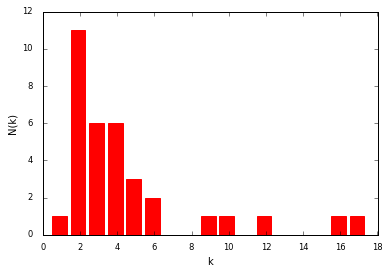

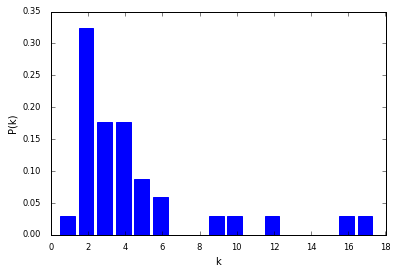

In [75]:
Ks, Ns = hist_integer_data(list_degrees, "k", "N(k)")

# normalize counts to get probability:
Ps = [1.0*n/sum(Ns) for n in Ns]
Ks = [v - 0.5 for v in Ks]

plt.bar(Ks,Ps, fc="blue",ec="blue")
plt.xlabel("k")
plt.ylabel("P(k)")
plt.show()

This network is very small, so the degree distribution looks pretty rough.

Let's generate a large network from some algorithm, and look at its degree distribution:

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 12282
Average degree:   4.9128


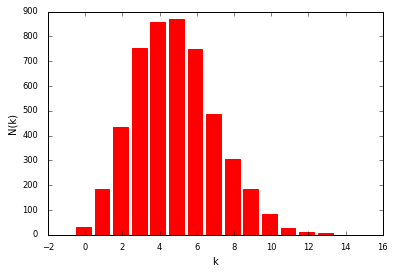

In [78]:
G1 = nx.erdos_renyi_graph(5000, 0.001) # some method with some parameters:
print(nx.info(G1))


list_degrees = [G1.degree()[x] for x in list(G1.nodes)]
Ks, Ns = hist_integer_data(list_degrees, "k", "N(k)")

Looking at the degree stats (from `nx.info`) the average degree is around 5, the maximum degree is 15 (see the plot). So I would argue that this network (whatever it is) **no hubs**.

Let's make another network of the same size:

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 9996
Average degree:   3.9984


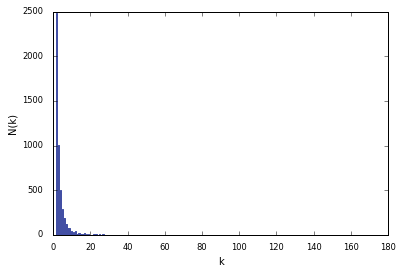

In [79]:
G2 = nx.barabasi_albert_graph(5000, 2) # some method with some parameters:
print(nx.info(G2))


list_degrees = [G2.degree()[x] for x in list(G2.nodes)]
Ks, Ns = hist_integer_data(list_degrees, "k", "N(k)", color=niceblu)

That looks very different, some nodes have **huge** degree. But it's a little hard to see the distribution. Logarithmic axes to the rescue!

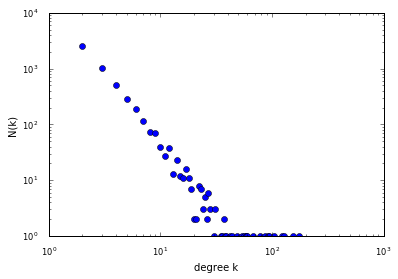

In [80]:
# just do a scatter plot of points at the tops of the bins:

plt.loglog(Ks, Ns, 'o')
plt.xlabel("degree k")
plt.ylabel("N(k)")
plt.show()

#### Moral of the story

We can bring back our data visualization techniques, like histograms, to explore network data. 

### Moving forward

Many more things to do with these networks. For example we can (roughly) draw them:

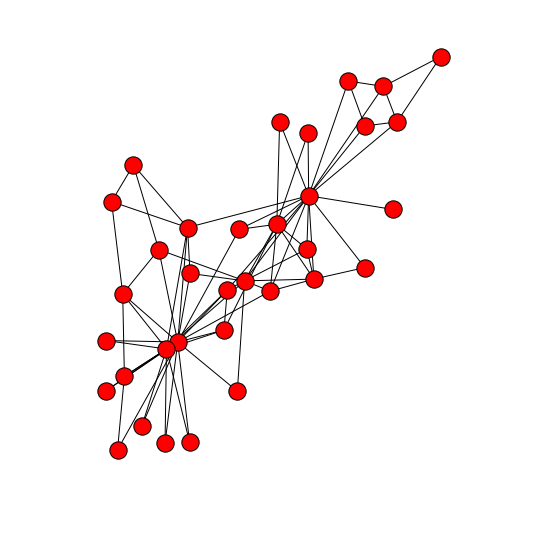

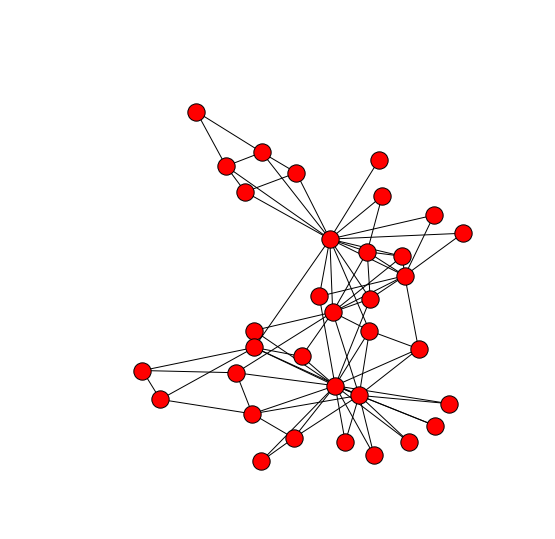

In [82]:
plt.figure(figsize=(7,7))

nx.draw(graph)
plt.show()

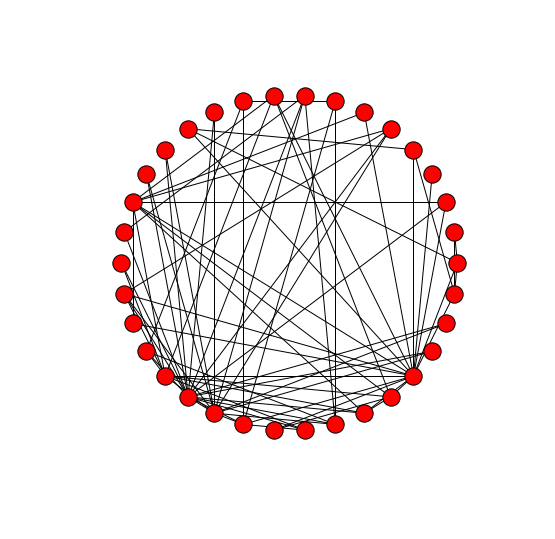

In [83]:
plt.figure(figsize=(7,7))
nx.draw_circular(graph)
plt.show()

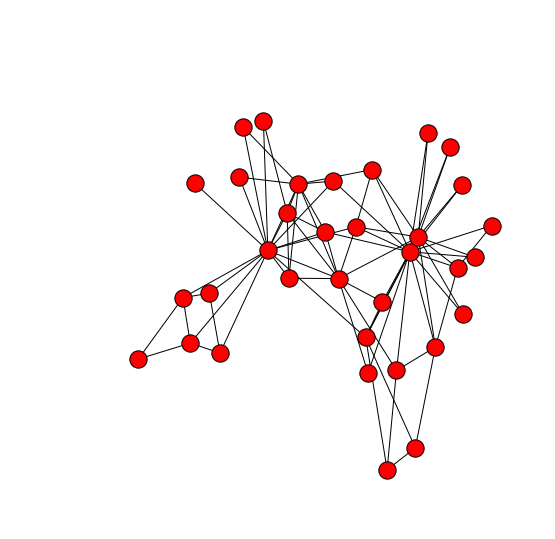

In [85]:
plt.figure(figsize=(7,7))
nx.draw_spring(graph)
plt.show()

This is pretty ugly, but it may be OK for debugging purposes, etc.

* Networkx has [a nice online gallery](http://networkx.github.io/documentation/latest/gallery.html) of other, fancier drawings.

* We will cover graph drawing in detail in the future.

# Summary

* Networks are very general beasts that can represent very different types of systems.
    + Lots of jargon and vocab, but most of it is fairly intuitive.

* Common/easy methods of storing/representing networks include **edgelists**, **adjacencey lists**, and **adjacency matrices**.

* Fancier file formats like **GraphML** or GML (which is not the same thing!) are handy if you don't need to write your own parsers. These are often used by big network toolboxes.

* We can use our existing techniques on networks by computing statistics such as the degrees of nodes. 

* Networkx has lots of goodies for working with networks. Highly recommended.